# Age and Sessions Played on a Minecraft Server

## Introduction

Minecraft is a popular 2011 computer game revolving around mining, crafting, and building in a sandbox environment. Players can play alone, in single-player worlds, or they can play together, on multiplayer servers. These multiplayer servers can be used, along with external data collection, to collect and observe a wealth of data on players and their behaviour. 

A UBC Computer Science research group, led by Frank Wood, created one of these servers and collected numerous datapoints on players, including their age, gender, newsletter subscription status, etc. as well as data on the server "sessions" they played (where sessions represent an individual playing on the server). 

People of different ages carry different interests, commitments, and hobbies, and this leads to differentials in how much time can be devoted to any specific task. To maximize the cost to benefit ratio of hosting a Minecraft server, the research group will naturally want to target players that will produce the most data (i.e. the players that play the most "sessions" on the Minecraft server). It would therefore be beneficial to know, and to ask: can age can predict sessions created on a multiplayer Minecraft server?

In [23]:
library(tidyverse)
library(tidyclust)
library(tidymodels)
set.seed(12345)

To begin to answer this question, we will first load in the libraries necessary to perform our wrangling, clustering, and visualization processes. We also set the seed to `12345` so that any functions requiring randomness in this file are fully reproducible.

In [24]:
player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")

head(player_data)
head(session_data)



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


We load in, and display the first six rows of each set of data we will be using. There are two sets we use:

Player data:

- Their experience (Pro, Veteran, Regular, Amateur, or Beginner.) Experience is initially read as the character type, but easily converted to and most usable as a factor)
- Whether they're subscribed to the mailing list (TRUE or FALSE, so of the logical type).
- Their hashed email (SHA256, and a character type)
- Hours they have spent playing (>= 0, a double)
- Name (character)
- Gender (male, female, non-binary, two-spirited, agender, other, or prefer not to answer). Initially read as a character, but easily converted to factor.
- Age (a whole number, or NA, of the type double or NA)
    
and session data, which keeps a record of each session, including: 

 - The player's hashed email (character),
 - Session start time and end time (local time, character) 
 - Original start and end time (Unix timestamps, double)

It is notable that in the session data, the end_time and original_end_time columns can contain NA values, likely representing sessions that were in progress when the data was exported. It is also notable that there is no information given in the files about how experience is reported (given the context, it is likely self-reported, but it is difficult to know for sure). Pertinently for our question, there is a lot more data about younger people than older people; we will continue on with our analysis with this in mind.

## Methods & Results

We will be performing a K-NN regression, since we don't know if the data has a linear relationship (and it is unlikely that age and sessions played actually does), so linear regression would be inappropriate here. K-NN regression requires less assumptions about the "shape" of our data, and is therefore a better choice. 

K-NN regression struggles with data that is outside the boundaries of the training data, but since we're only trying to determine how age effects session data roughly within the boundaries of our dataset (it would be unreasonable to target 1 year olds, or 99 year olds for playing Minecraft), K-NN is still an appropriate choice. K-NN is also tough on computational resources in general, but we have a small enough data set this isn't a constraint.

First, we will clean our data, and select our necessary columns. For our player data, we will select the columns corresponding to experience and hashed email (so we can link each player to their sessions). 

We will rename the columns `Age` to `age` and `hashedEmail` to `hashed_email` for naming convention standardization. We'll also drop any players that have an N/A age, as we'll be unable to use them in our regression later on.

In [25]:
clean_player_data <- player_data |>
    rename(hashed_email = hashedEmail, age = Age) |>
    select(hashed_email, age) |> 
    drop_na(age) 

head(clean_player_data)


hashed_email,age
<chr>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,21
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,21
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,17


Next, we'll clean up our session data. Similarly to the player data above, we'll rename `hashedEmail` to `hashed_email`, and only select that column, as we're only interested in the number of sessions, not the length of sessions.

In [26]:
clean_session_data <- session_data |>
    rename(hashed_email = hashedEmail) |>
    select(hashed_email)
head(clean_session_data)

hashed_email
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf


Recall that a hashed email is a unique identifier for each player. Since we're interested in the amount of sessions each player created, we'll use `summarise` with `group_by` to get the amount of sessions created by each player. 

In [27]:
sessions_by_email <- clean_session_data |>
    group_by(hashed_email) |>
    summarise(session_count = n())
head(sessions_by_email)

hashed_email,session_count
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1


Now that our data is clean, and our session data has hashed_emails linked to their session count, we can combine these two data sets into one, so we can more easily visualize it. We'll do this by matching our `hashed_email`s to each player, and adding the count column. We'll use `left_join` for this, since we don't want to lose data from players that have no sessions (but it's okay if we lose data from sessions which we have no player data for, since we can't use this in our analysis). 

We'll also replace any NA counts with zero, because a count of NA means that the player had 0 sessions in our data.

Since our data is combined, we also now can remove `hashed_email`.

In [28]:
combined_session_player_data <- left_join(clean_player_data, sessions_by_email, by = "hashed_email") |>
    mutate(session_count = replace_na(session_count, 0)) |>
    select(-hashed_email)
head(combined_session_player_data)


age,session_count
<dbl>,<int>
9,27
17,3
17,1
21,1
21,1
17,0


Now that we have our data, we can start building our regression workflow. First, let's split our data into training data and test data, with a proportion of 0.75. Our `strata` is session_count, since that's what we want to predict based on player age.

In [29]:
ps_split <- initial_split(combined_session_player_data, prop = 0.75, strata = session_count)
ps_training <- training(ps_split)
ps_testing <- testing(ps_split)

Next, let's make our recipe. Remember, we'll only use our training data for making our recipe and model. Our explanatory variable is age, and our response variable is session count. Since we're performing a K-NN regression, we need to scale and centre our predictors, since our two variables have much different ranges (for age, 8-50, and for session count, 0-310).

In [30]:
ps_recipe <- recipe(session_count ~ age, data = ps_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


Now we can make our regression model. Since we don't know the ideal amount of neighbours yet, we'll set `neighbors = tune()`. We'll also make our weight function rectangular, so each neighbour gets an equal "vote". We'll be using the `kknn` engine here in the regression mode.

In [31]:
ps_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

We can now put it all together in our workflow. We won't fit our data yet, since we still need to figure out what K to use.

In [32]:
ps_workflow <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(ps_spec)

Next we can make our cross-validation object, to make sure we aren't overfitting our data. We'll make it 5-fold, and set our strata to be `session_count`, as that's what we're trying to predict. Again, we'll be using our training data only.

In [33]:
ps_vfold <- vfold_cv(ps_training, v = 5, strata = session_count)

Now we'll use our cross-validation object, and the workflow we made, to collect metrics on various K values. We specify the K values to use in a tibble we'll create using the tibble and seq functions. We'll test K from 1 - 30, with a step of 2. 

In [34]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1)) # this creates a table with a 
                                                              # 'neighbours' column with all numbers 1-100

ps_results <- ps_workflow |>
    tune_grid(resamples = ps_vfold, grid = k_vals) |>
    collect_metrics() 
head(ps_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,31.970182022,5,7.981207506,Preprocessor1_Model001
1,rsq,standard,0.018573751,5,0.011642630,Preprocessor1_Model001
2,rmse,standard,32.249143243,5,9.155041612,Preprocessor1_Model002
2,rsq,standard,0.037413469,5,0.028645872,Preprocessor1_Model002
3,rmse,standard,29.023945051,5,8.554375332,Preprocessor1_Model003
3,rsq,standard,0.009117956,5,0.002226359,Preprocessor1_Model003


What we're interested in here is the root mean squared error, or `rmse`. This is a measure of how well our model performs with each K value. A great part of the `collect_metrics` function is that it is very easy to visualize how our RMSE changes over each K value, which has been done below. To do this, we'll filter for the number of neighbours, K, and the mean (this is our actual RMSE value), and then plot them using `ggplot`.

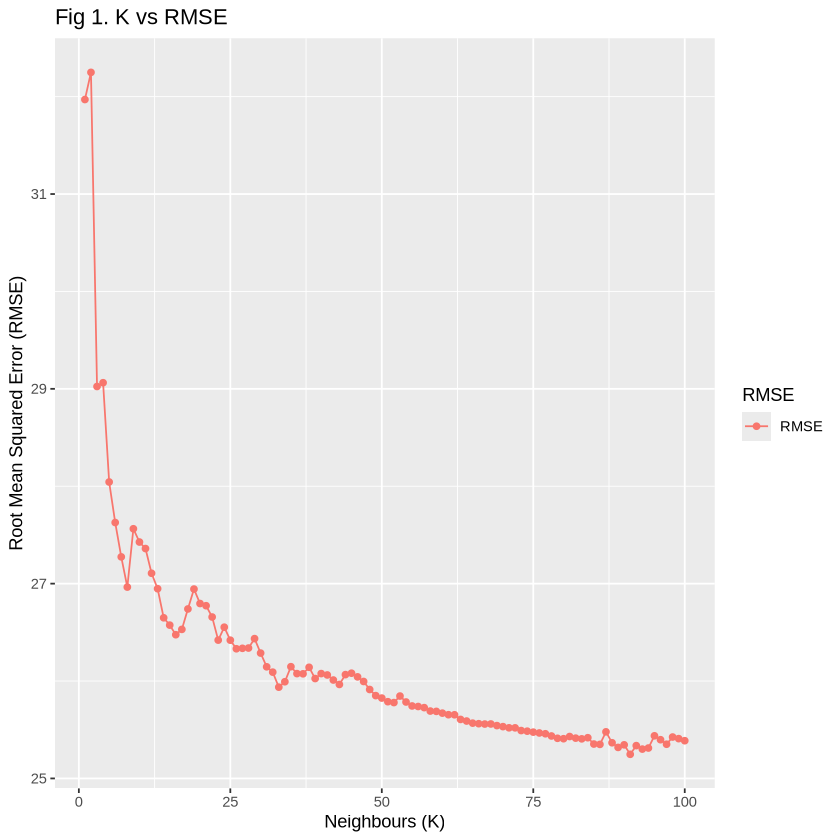

In [35]:
k_vs_mean <- ps_results |>
    filter(.metric == "rmse") |>
    select(neighbors, mean)
k_vs_mean_plot <- k_vs_mean |> 
    ggplot(aes(x = neighbors, y = mean, color = "RMSE")) + 
    geom_point() + 
    geom_line() +
    labs(x = "Neighbours (K)", y = "Root Mean Squared Error (RMSE)", title = "Fig 1. K vs RMSE", color = "RMSE")
k_vs_mean_plot

We want to minimize our RMSE, so we'll sort `k_vs_mean` from least to greatest RMSE, and pull our best K value!

In [36]:
best_k_val <- k_vs_mean |>
    arrange(mean) |> # arranges the data from least to greatest by mean
    slice(1) |>
    pull(neighbors)
best_k_val



[1] 91

The amount of neighbours with the lowest RMSPE is K = 91, so this is the value we will use. 
Now we can test our predictions using our K value on our testing data. 

To set this up, we'll need to create a new model with our new K value, similar to the one we created above. We can reuse our recipe from before, since it doesn't need to change now that we know the best K. Additionally, we can now fit our workflow on our training data, since we know our K value.

In [37]:
new_ps_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_val) |>
  set_engine("kknn") |>
  set_mode("regression")
new_ps_workflow <- workflow() |>
    add_recipe(ps_recipe) |>
    add_model(new_ps_spec) |>
    fit(data = ps_training)



Now we can actually test our workflow on our testing data. We'll `predict` the session_count for our testing data, bind our prediction to the columns, and then compare them to the actual values using `metrics`. 

In [38]:
ps_metrics <- new_ps_workflow |>
  predict(ps_testing) |>
  bind_cols(ps_testing) |>
  metrics(truth = session_count, estimate = .pred)
ps_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,42.15939747
rsq,standard,0.08432537
mae,standard,15.73716080


The root mean square predicted estimate (like RMSE, but when we're using our testing data) estimate in our metrics means that we expect there to be an average error of 42.16 in each of our predicted session counts. This is a *very* high error considering most of our players have 0-5 sessions, so let's visualize what's happening here. 

We'll have our model predict a session count value for every age 5-60, and graph it against our actual data.

The points are our actual data, and the red line is what our model predicts for each value between 5 and 60 (our endpoints are just beyond the age range in our data).

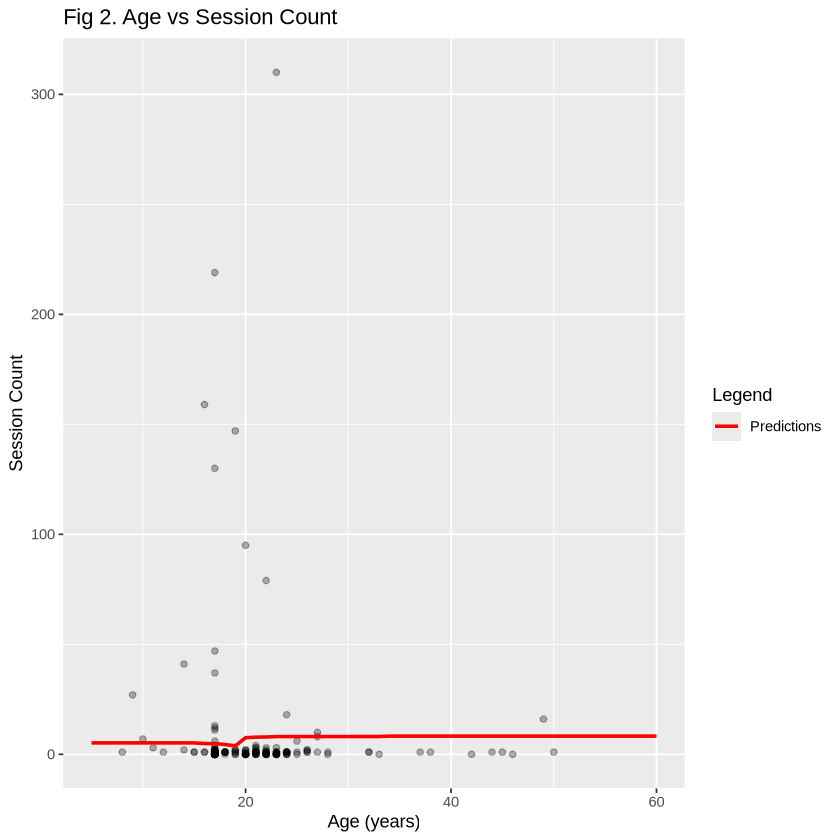

In [39]:
age_pred_grid <- tibble(
    age = seq(
        from = 5,
        to = 60,
        by = 1
    )
) # A tibble of all the ages we want to predict: 5-60, with a step of 1.

ps_preds <- new_ps_workflow |>
  predict(age_pred_grid) |>
  bind_cols(age_pred_grid) # attaches the predicted session count to the tibble of the ages we wanted to predict



ps_plot <- ggplot(combined_session_player_data, aes(x = age, y = session_count)) +
  geom_point(alpha = 0.3) + # sets transparency of the points
  geom_line(data = ps_preds,
            mapping = aes(x = age, y = .pred, color = "Predictions"), # Mapping required to make legend form correctly
            linewidth = 1) +
  labs(x = "Age (years)", y = "Session Count", color = "Legend") +
    ggtitle("Fig 2. Age vs Session Count") +
    scale_color_manual(values = c("Predictions" = "red")) 

ps_plot

It looks like we have some pretty significant outliers here that makes it difficult for us to see our model performs. Let's zoom in, and only look at our line when session count is between 0 and 20 (where most of our data falls).

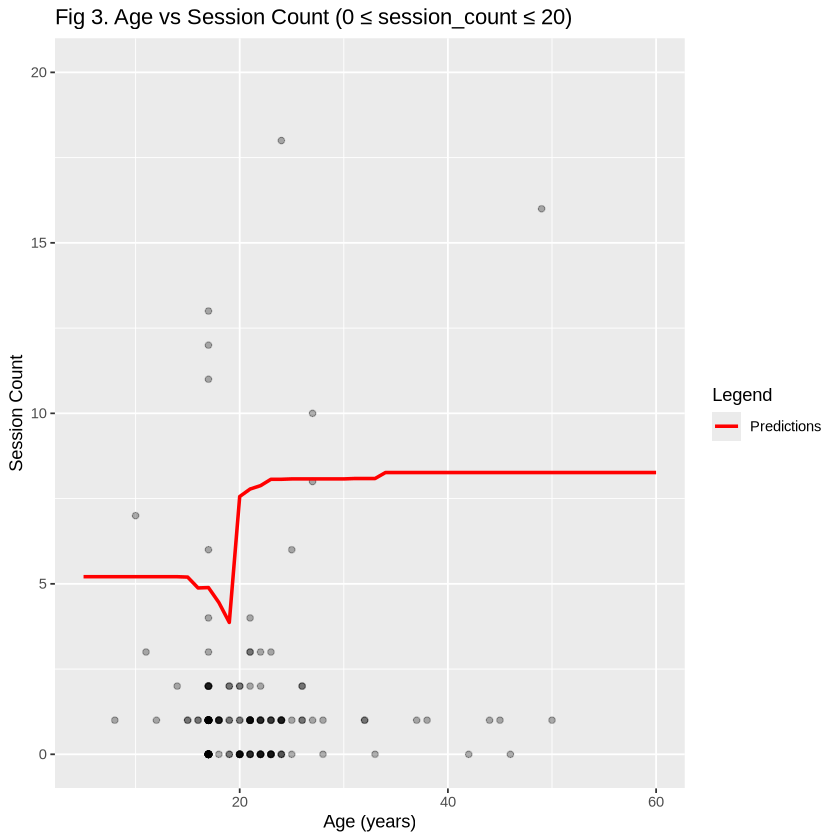

In [40]:
zoomed_in_plot <- ps_plot + 
    coord_cartesian(ylim=c(0, 20)) + 
    ggtitle("Fig 3. Age vs Session Count (0 ≤ session_count ≤ 20)") 
zoomed_in_plot

## Discussion 

As we would expect from our high error (and made more clearly by zooming in) our model doesn't perform very well. It is important for us to stop and ask ourselves why.

The answer is that there are extremely significant outliers in our data that make it very difficult to build a good regression model. There are players with sessions counts over 300, while most players have a session count between 0 and 5. The outliers in the data confuse the regression model to the point where the predictions are essentially useless. The model could be significantly improved by ignoring these outliers, although the statistical tools to determine which data can be reasonably exluded is beyond the scope of this course. 

Looking at the zoomed-in graph, however, it appears that in general, average session count decreases with age. Although this should be analyzed by a more rigorous statistical analysis, this makes sense, intuitively; middle-to-older-age adults often have less interest in video games and more outside obligations, like childcare, than younger people. 

This is the expected result of this report, and if it is indeed true, it means that Frank Wood's research group should target teenagers and young adults to join their Minecraft server, as these are the players that create the most sessions and therefore produce the most data. 

There are many further avenues to explore, and many variables in these data sets that could possibly be correlated with age. Some more interesting examples that could be explored for the research group are the effects of age on newsletter subscription, the relationship between age and relative Minecraft experience, and the relationship between age and hours played. For all of these, it is still important to consider the effect outlier data may have on the analysis, as it may have similarly significant impacts that the outliers did on this analysis.

Project created by Nathan Harris and hosted on https://github.com/harris3315/dsci-100-project